Comparing two calculations of the percentage of a census tract's population on well water:
  1. The approach taken by Johnson et al 2019.
  2. Via population density estimates via [CEISIN and Facebook](https://data.humdata.org/dataset/united-states-high-resolution-population-density-maps-demographic-estimates#); [Link 2](https://dataforgood.facebook.com/dfg/tools/high-resolution-population-density-maps).

In [1]:
import geopandas
import pandas as pd
import matplotlib.pyplot as plt

# Method 1: Johnson

In [2]:
Johnson_data = geopandas.read_file("/Users/Scott/QGIS/SVI/Well Water Pop/Johnson Pop Ests.gpkg", layer="WW_pop_ests")

# Method 2: Using Pop Density

In [3]:
density_data = pd.read_csv("/Users/Scott/QGIS/SVI/Penn_Analysis/data/final_output.csv")

CEISIN no-pop estimates can be:
  - 0
    - indicates that a tract had area not served by a PWS, but this area had an estimated population of 0 (i.e. no buildings)
  - NA
    - indicates a tract was 100% served by a PWS, so the WW component is non-existent.

In [4]:
density_data["WWR_sum_pop_est"] = density_data["WWR_sum_pop_est"].fillna(0)
density_data["WW_pop_CEISIN_direct"] = density_data["WWR_sum_pop_est"]

In [5]:
density_data["frac_WW_CEISIN"] = density_data["WWR_sum_pop_est"] / density_data["TL_sum_pop_est"]

# Join Two Estimates

In [6]:
Johnson_data.dtypes

STATEFP         object
COUNTYFP        object
TRACTCE         object
GEOID           object
NAME            object
NAMELSAD        object
MTFCC           object
FUNCSTAT        object
ALAND            int64
AWATER           int64
INTPTLAT        object
INTPTLON        object
WW_pop_BGM     float64
WW_pop_REM     float64
geometry      geometry
dtype: object

In [7]:
density_data.dtypes

STATEFP                   int64
COUNTYFP                  int64
TRACTCE                   int64
GEOID                     int64
NAME                    float64
                         ...   
Shape_Area              float64
TL_sum_pop_est          float64
WWR_sum_pop_est         float64
WW_pop_CEISIN_direct    float64
frac_WW_CEISIN          float64
Length: 177, dtype: object

In [8]:
density_data["GEOID"] = density_data["GEOID"].astype("string")
Johnson_data["GEOID"] = Johnson_data["GEOID"].astype("string")

In [9]:
Johnson_data.dtypes

STATEFP               object
COUNTYFP              object
TRACTCE               object
GEOID         string[python]
NAME                  object
NAMELSAD              object
MTFCC                 object
FUNCSTAT              object
ALAND                  int64
AWATER                 int64
INTPTLAT              object
INTPTLON              object
WW_pop_BGM           float64
WW_pop_REM           float64
geometry            geometry
dtype: object

In [10]:
density_data.dtypes

STATEFP                          int64
COUNTYFP                         int64
TRACTCE                          int64
GEOID                   string[python]
NAME                           float64
                             ...      
Shape_Area                     float64
TL_sum_pop_est                 float64
WWR_sum_pop_est                float64
WW_pop_CEISIN_direct           float64
frac_WW_CEISIN                 float64
Length: 177, dtype: object

These are NA b/c TL_sum_pop_est == 0
The ACS (in the SVI) also estimates a pop of 0 (E_TOTPOP)

In [11]:
density_data_zero_pops = density_data[density_data["frac_WW_CEISIN"].isna()]

In [12]:
density_data_to_join = density_data.loc[:,["GEOID", "E_TOTPOP", "WW_pop_CEISIN_direct", "frac_WW_CEISIN"]]
comparison_data = Johnson_data.merge(
    density_data_to_join,
    on="GEOID",
    how="outer"
)

## WW Users at Pop Count

In [13]:
comparison_data["WW_pop_CEISIN_ACS"] = comparison_data["E_TOTPOP"] * comparison_data["frac_WW_CEISIN"]

In [14]:
comparison_data["pop_diff_WW_BGM"] = comparison_data["WW_pop_CEISIN_ACS"] - comparison_data["WW_pop_BGM"]
comparison_data["pop_diff_WW_REM"] = comparison_data["WW_pop_CEISIN_ACS"] - comparison_data["WW_pop_REM"]

### Total WW Pop Estimates

According to the paper, this *should* be ~3 million.

In [15]:
comparison_data.loc[:,["WW_pop_CEISIN_direct", "WW_pop_CEISIN_ACS", "WW_pop_BGM", "WW_pop_REM"]].sum()

WW_pop_CEISIN_direct    2.417985e+06
WW_pop_CEISIN_ACS       2.377883e+06
WW_pop_BGM              2.207474e+06
WW_pop_REM              2.207361e+06
dtype: float64

# Plot

## Pop Diffs

<Axes: >

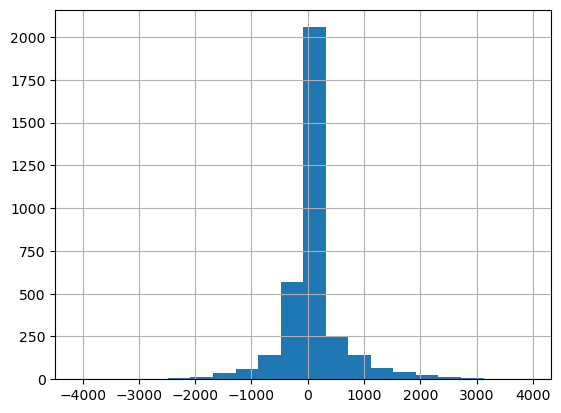

In [16]:
comparison_data["pop_diff_WW_REM"].hist(bins=20)

Interesting... the line going up y-axis at x near 0. How does the pop est change if I truncate to >10 or so for pop dens estimate?

## DISC
This discrepancy should make the two estimates closer, because near-zero values via CIESIN are corresponding to sometimes large values via Johnson. Perhaps these scenarios represent cases where a small community got on a PWS? I don't see how else Johnson would estimate wells somewhere that CIESIN says there's nearly no buildings.

TODO: look at the specific areas w/ big discrepancies

For areas w/ small CIESIN est, it looks like the've been covered by a PWS
For areas w/ big CIESIN est, it looks like the've got little to no PWS, so I'm guessing it's just a pop est difference. CIESIN will be more accurate, as I'm using up-to-date ACS numbers with it.

**We'll play it, Steve! Use my own numbers!**


Text(0, 0.5, '# Well Water Users, using Johnson REM')

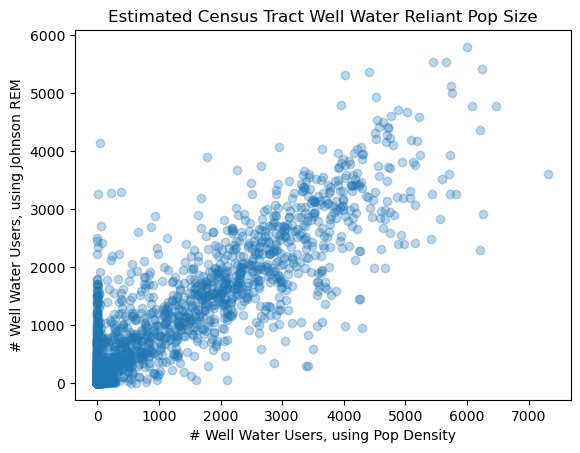

In [35]:
fig, ax = plt.subplots()
ax.scatter(
    comparison_data["WW_pop_CEISIN_ACS"], 
    comparison_data["WW_pop_REM"],
    alpha=0.3)
ax.set_title("Estimated Census Tract Well Water Reliant Pop Size")
ax.set_xlabel("# Well Water Users, using Pop Density")
ax.set_ylabel("# Well Water Users, using Johnson REM")

In [24]:
non_lo_WW_pop_dens_ests = comparison_data[comparison_data["WW_pop_CEISIN_ACS"] > 10]

Text(0, 0.5, '# Well Water Users, using Johnson REM')

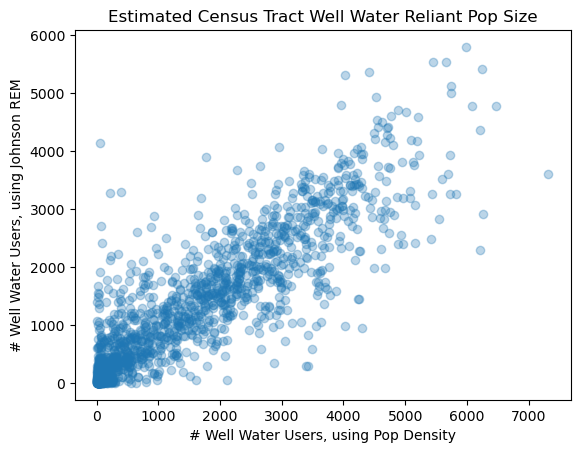

In [25]:
fig, ax = plt.subplots()
ax.scatter(
    non_lo_WW_pop_dens_ests["WW_pop_CEISIN_ACS"], 
    non_lo_WW_pop_dens_ests["WW_pop_REM"],
    alpha=0.3)
ax.set_title("Estimated Census Tract Well Water Reliant Pop Size")
ax.set_xlabel("# Well Water Users, using Pop Density")
ax.set_ylabel("# Well Water Users, using Johnson REM")

In [26]:
non_lo_WW_pop_dens_ests.loc[:,["WW_pop_CEISIN_direct", "WW_pop_CEISIN_ACS", "WW_pop_BGM", "WW_pop_REM"]].sum()

WW_pop_CEISIN_direct    2.416546e+06
WW_pop_CEISIN_ACS       2.376932e+06
WW_pop_BGM              2.013157e+06
WW_pop_REM              2.013025e+06
dtype: float64

## 3: CEISIN Pop WW vs Johnson Pop WW

In [28]:
WW_CEISIN_Pop_diffs = (comparison_data["WW_pop_CEISIN_ACS"] - comparison_data["WW_pop_REM"]).to_frame(name="diff")

In [29]:
WW_CEISIN_Pop_diffs["quantile"] = WW_CEISIN_Pop_diffs.loc[:,["diff"]].rank() / len(WW_CEISIN_Pop_diffs)

In [30]:
WW_CEISIN_Pop_diffs.sort_values("quantile", inplace=True)

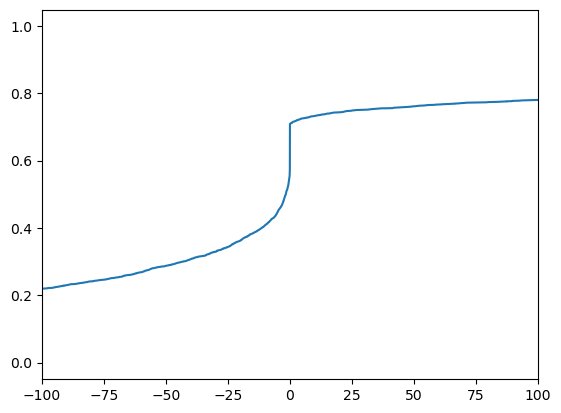

In [33]:
fig, ax = plt.subplots()
ax.set_xlim(-100, 100)
ax.plot("diff", "quantile", data=WW_CEISIN_Pop_diffs)